In [11]:
# %pip install graphviz
# import os
# dot_path = r"C:\Program Files\Graphviz\bin\dot.exe"
# if not os.path.exists(dot_path):
    # raise FileNotFoundError("未找到 Graphviz dot 可执行文件，请安装到 C\\Program Files\\Graphviz\\bin\\dot.exe 或更新路径。")
# os.environ["GRAPHVIZ_DOT"] = dot_path
# os.environ["PATH"] = os.path.dirname(dot_path) + os.pathsep + os.environ.get("PATH", "")
# from graphviz import backend
# backend.dot_command = os.environ["GRAPHVIZ_DOT"]

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

In [4]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):#fallback string representation
    return f"Value(data={self.data})"
  
  def __add__(self, other):#overload + operator
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other): #overload * operator
    other = other if  isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __rmul__(self, other):  #right-side multiplication
    return self * other
  
  def __pow__(self, other): #overload ** operator
    out = Value(self.data**other, (self, ), f'**{other}')
    
    def _backward():
      self.grad += other * (self.data**(other -1)) * out.grad
    out._backward = _backward
    
    return out
  def __neg__(self):  #overload unary - operator
    return self * Value(-1.0)
  
  def __sub__(self, other):   #overload - operator
    return self + (-other)
  
  def __truediv__(self, other):   #overload / operator
    return self * other**-1
  
  def exp(self):    #exponential function   
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward(): 
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  def log(self):  #natural logarithm
    x = self.data
    out = Value(math.log(x), (self, ), 'log')
    
    def _backward():
      self.grad += (1/x) * out.grad
    out._backward = _backward
    
    return out

  def tanh(self):   #hyperbolic tangent function
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self): #backpropagation
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()




$\tanh(x)=\frac{e^{2x}-1}{e^{2x}+1}$

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [6]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b=Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
y=x1w1x2w2 + b; y.label='y'
o=((2*y).exp()-1)/((2*y).exp()+1); o.label='o'

In [7]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b=Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
y=x1w1x2w2 + b; y.label='y'
oh=y.tanh(); oh.label='oh'

In [8]:
o.backward()

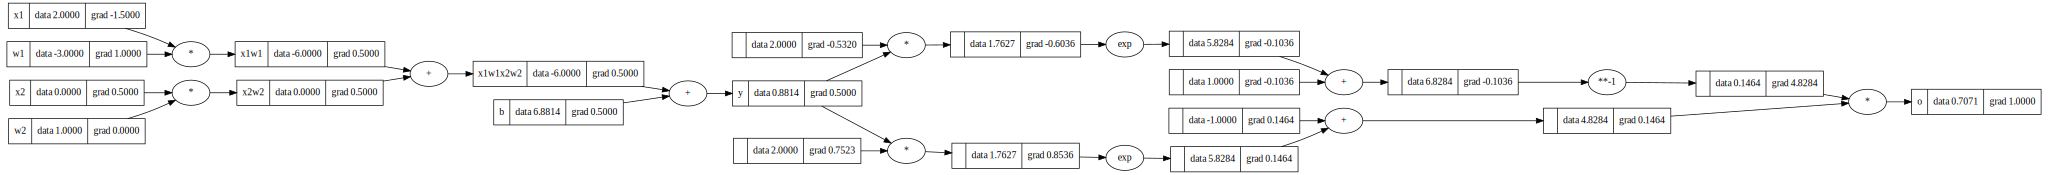

In [9]:
draw_dot(o)

In [10]:
oh.backward()

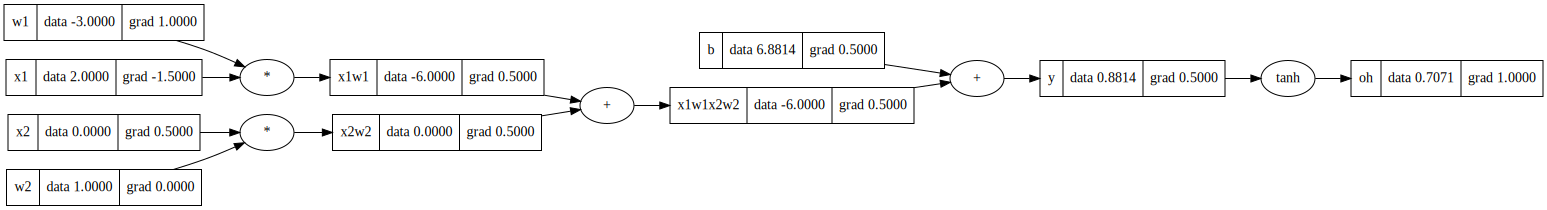

In [11]:
draw_dot(oh)

映射关系的内部延拓不影响原有梯度反向传播结果

In [14]:
%pip install torch


   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB 640.0 kB/s eta 0:02:54
   ---------------------------------------- 0.1/110.9 MB 650.2 kB/s eta 0:02:51
   ---------------------------------------- 0.1/110.9 MB 744.7 kB/s eta 0:02:29
   ---------------------------------------- 0.1/110.9 MB 717.5 kB/s eta 0:02:35
   ---------------------------------------- 0.2/110.9 MB 853.3 kB/s eta 0:02:10
   ---------------------------------------- 0.2/110.9 MB 942.1 kB/s eta 0:01:58
   ---------------------------------------- 0.3/110.9 MB 1.0 MB/s eta 0:01:47
   ---------------------------------------- 0.4/110.9 MB 1.1 MB/s eta 0:01:44
   ---------------------------------------- 0.5/110.9 MB 1.1 MB/s eta 0:01:39
   ---------------------------------------- 0.6/110.9 MB 1.4 MB/s eta 0:01:19
   ---------------------------------------- 0.8/110.9 MB 1.6 MB/s eta 0:01:09
   ---------------------------------------- 1.0/110.9 MB 1.

In [6]:
import torch

In [14]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad_(True)
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad_(True)
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad_(True)
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad_(True)
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad_(True)
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [15]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [16]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [17]:
torch.Tensor([2.0]).double()

tensor([2.], dtype=torch.float64)

In [20]:
o.item()

0.7071066904050358

神经网络基本认识[networkDefinition]，我们首先按照下图定义神经元

[networkDefinition]: https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w02/terms.html

![基本神经元数学结构](neuron_model.jpeg "基本神经元数学结构")

In [12]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]#[]用于收集成为列表，作为神经元输入的权重
        self.b = Value(np.random.uniform(-1, 1))#偏置用于控制神经元整体的触发频率
        
    def __call__(self, x):
        #n=n(x)=n.__call__(x)=w*x+b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)#self.b作为sum的初始值,可以增加计算效率
        #wi*xi for wi, xi in zip(self.w, x)作为生成器表达式，在python中必须用括号包裹
        out = act.tanh()
        return out
    
    def parameters(self):
        #收集Neuron参数，输出向量格式
        return self.w + [self.b]
    


In [13]:
x=[2.0, 3.0]
n=Neuron(2)
n(x)

Value(data=-0.9752283164181957)

In [14]:
##zip 可以将迭代器整合
print(list(zip([1,2,3], [5,6])))

[(1, 5), (2, 6)]


In [15]:
print(list(zip([1,2,3], [4,5,6])))

[(1, 4), (2, 5), (3, 6)]


In [16]:
print(list(zip([1,2,3], [4,5,6], [7,8,9])))

[(1, 4, 7), (2, 5, 8), (3, 6, 9)]


接下来定义神经层

![基本神经层图连接结构](neuron_Layel.jpg "基本神经层图连接结构")

层结构是独立的神经元的集合

In [17]:
class Layer:
    def __init__(self, nin, nout):
        #初始化层内的每一个独立神经元，根据Neuron的定义，初始参数都是随机的
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        #调用层时，将输入传递给层内的每个神经元（全连接），收集它们的输出
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for Neuron in self.neurons for p in Neuron.parameters()]

In [18]:
n=Layer(2,4)
n(x)

[Value(data=-0.8190136513797177),
 Value(data=-0.9164864561450996),
 Value(data=-0.9998786809021387),
 Value(data=0.0013179775599389558)]

接下来将不同层连接起来，组建多层感知器（MLP）

In [19]:
[3]+[1,2,3]

[3, 1, 2, 3]

In [20]:
class MLP:
    def __init__(self, nin, nouts):
        ##这里的nouts是所有Layer中的nout构成的向量。nin是初始层接受的输入向量维度
        ##后续层接受的输入层维度由上一层的nout决定，因此设计sz和Layer(sz[i],sz[i+1])
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        #输入向量在不同层迭代更新
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for Layer in self.layers for p in Layer.parameters()]

In [38]:
T = MLP(3,[4,4,1])
o=[Value(1), Value(2), Value(3)]
T(o)
print(len(T.parameters()))
T.parameters()

41


[Value(data=-0.013130648811768175),
 Value(data=-0.6987241103778441),
 Value(data=-0.7480558871049818),
 Value(data=0.28406081737262867),
 Value(data=-0.29633945191812505),
 Value(data=-0.02421316848235433),
 Value(data=-0.41075430089302833),
 Value(data=-0.8056079120291879),
 Value(data=-0.43252802306157),
 Value(data=0.1520660260679909),
 Value(data=-0.7247520627699928),
 Value(data=-0.6972982185172973),
 Value(data=0.19009932779980154),
 Value(data=0.6440147761390065),
 Value(data=-0.3461254446386586),
 Value(data=-0.7458655211304273),
 Value(data=-0.7048723920695337),
 Value(data=0.7741316019097848),
 Value(data=0.09048152663462461),
 Value(data=-0.1075036873368429),
 Value(data=-0.048636528152658176),
 Value(data=-0.42066746774285924),
 Value(data=-0.5978125810151251),
 Value(data=-0.7790353918322195),
 Value(data=0.49239762649415586),
 Value(data=0.049964819769375834),
 Value(data=0.10777954837011072),
 Value(data=-0.6451143146533194),
 Value(data=0.5200725263489558),
 Value(data

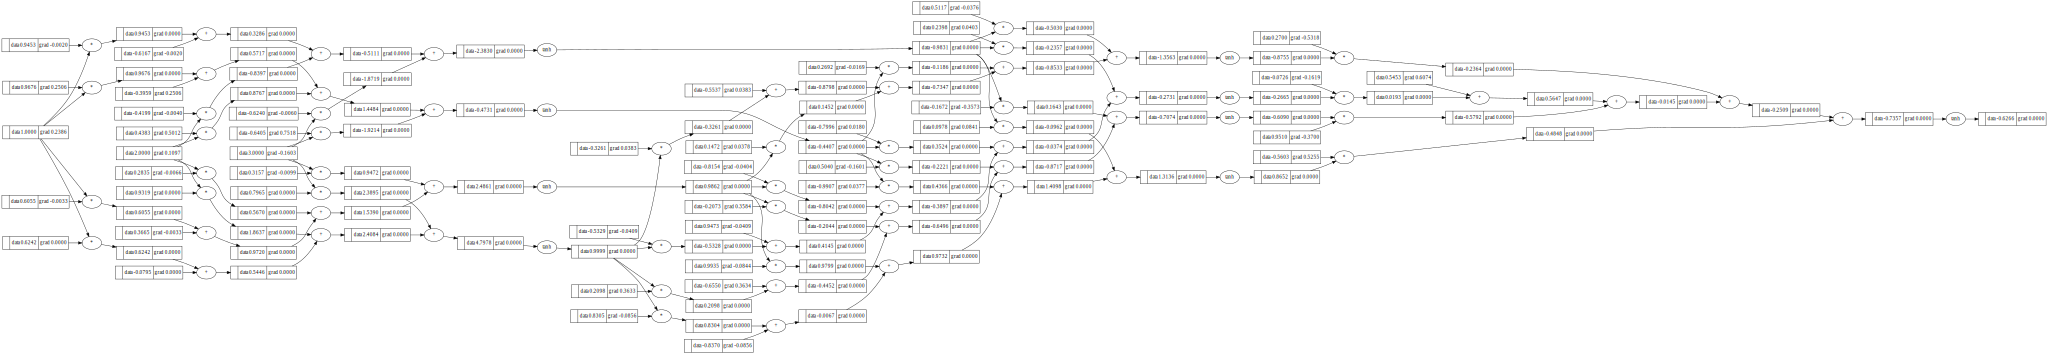

In [22]:
T(o).backward()
draw_dot(T(o))

##注意，这种写法会导致梯度被覆盖，画的图会不对，这是因为，
##T(o).backward()和draw_dot(T(o))本质上是两个T(o)，虽然T的参数没有发生改变(o的输入只调用了T的__call__,没激活初始化，因而没有wi和bi的随机化)
##但是,由于迭代调用__call__,最终会调用到act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)，这里的x就是输入的o
##对于内部的Value类算子来说，xi相当于一个新的输入，因此得到wi*xi是一个新的初始化的Value，其grad为0，第一步的T(o).backward()并没有更新这部分的梯度
##之所以看到部分draw_dot(T(o))部分Value的grad不为0，是因为原有的+self.b并没有重新初始化，因此对应的节点位置grad不为0

In [23]:
draw_dot(T(o).backward())
##这种调用方式也是错误的，T(o).backward()本身是执行所有向前传播过程的，没有返回值

AttributeError: 'NoneType' object has no attribute '_prev'

In [24]:
# 重要：保存前向传播的输出结果
# 每次调用T(o)都会创建新的计算图（新的Value对象），虽然网络参数相同
# 为了正确进行反向传播和可视化，必须保存并使用同一个输出对象
result = T(o)
result.backward()

In [25]:
result.grad

1.0

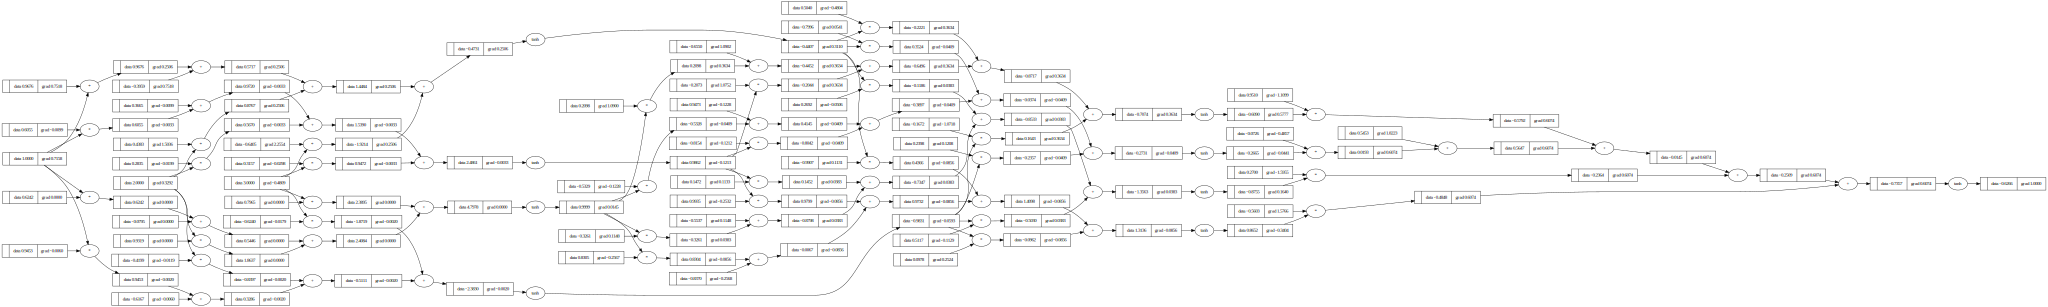

In [26]:
draw_dot(result)

基于以上随机生成的网络，接下来给出我们希望的输入和输出，看看网络的效果

In [39]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]##这是期望输出，看得出来是一个二分类问题
ypred = [T(x) for x in xs]
ypred

[Value(data=-0.9460616797298851),
 Value(data=-0.8471307974458947),
 Value(data=-0.9448199345791769),
 Value(data=-0.9194730731898058)]

In [40]:
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
loss

Value(data=7.497946772723193)

In [29]:
loss.backward()

In [30]:
T.layers[0].neurons[0].w[0].label='w111'
T.layers[0].neurons[0].w[0].grad

-0.566094774004572

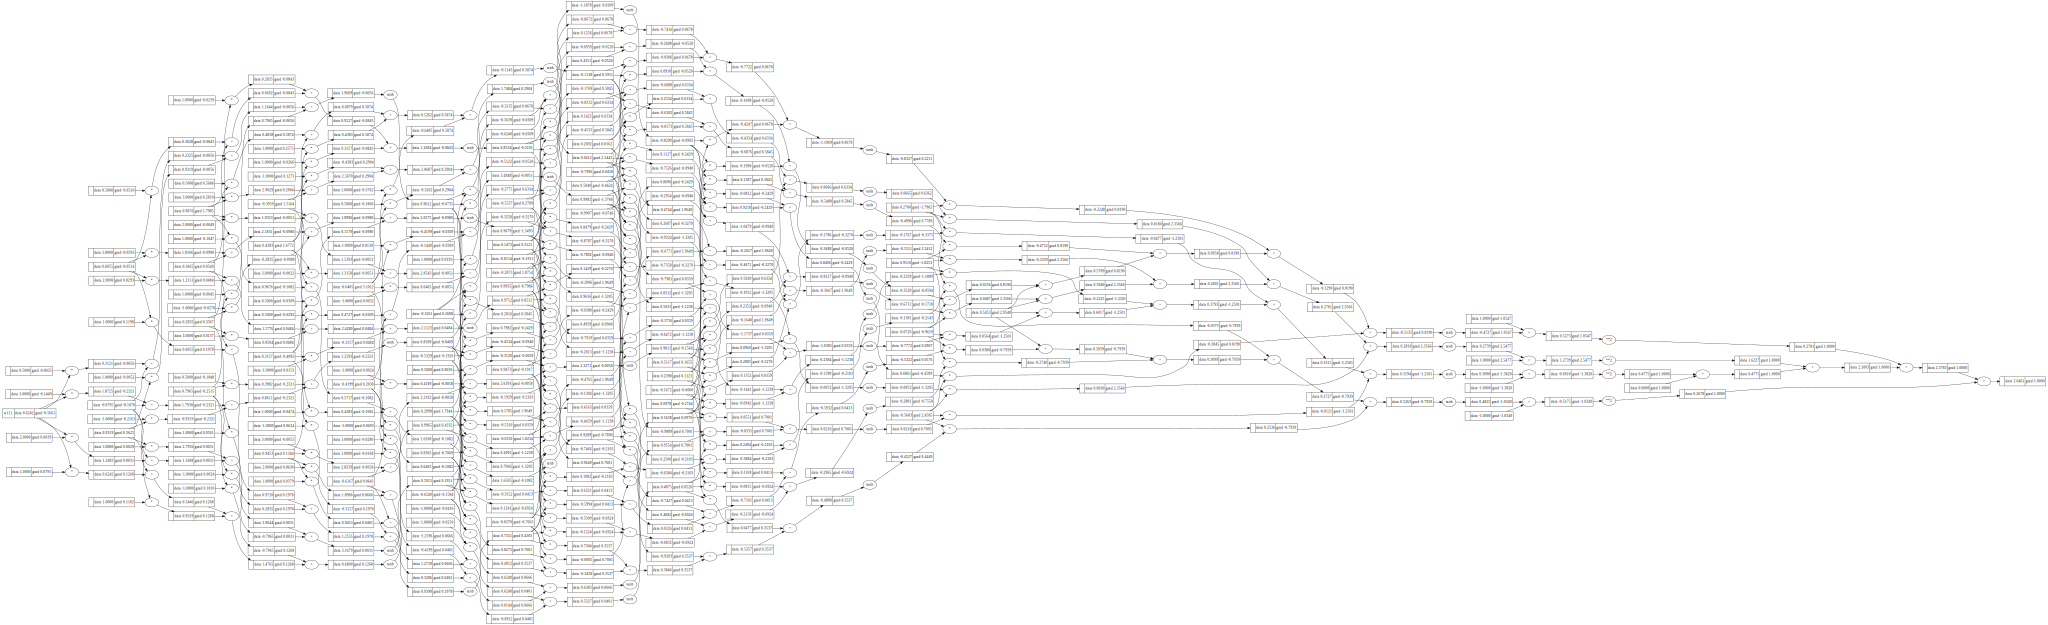

In [31]:
draw_dot(loss)

In [32]:
for p in T.parameters():
    p.data += -0.01 * p.grad

In [33]:
ypred = [T(x) for x in xs]
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
loss

Value(data=2.4960825535913793)

In [34]:
x = [2, 5, 6]
T(x)

Value(data=-0.6865880543292403)

In [ ]:
for k in range(20):

    for p in T.parameters():
        p.grad = 0.0 #重置梯度，否则会累加
    ypred = [T(x) for x in xs]
    loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
    loss.backward()
    
    for p in T.parameters():
        p.data += -0.05 * p.grad

    print(k,loss.data)

0 7.497946772723193
1 7.214448946055472
2 6.3972846567839134
3 3.1656227732557642
4 1.1468755912448236
5 0.6499761929873669
6 0.44218380170603244
7 0.3253654071157867
8 0.2530588427092928
9 0.20490242068005493
10 0.17095535886993665
11 0.14594227859298842
12 0.12685532634578578
13 0.1118738736591457
14 0.09983990953538915
15 0.08998578332141435
16 0.08178457787411295
17 0.07486373416953235
18 0.06895303477982455
19 0.06385211054701377


In [42]:
ypred

[Value(data=0.8661324616079438),
 Value(data=-0.8961541337520189),
 Value(data=-0.873742172492995),
 Value(data=0.8614121586563853)]